In [ ]:
# https://medium.com/red-buffer/training-an-object-detection-model-in-a-few-minutes-using-detectron2-5bd0aa5550d4

In [ ]:
#zipfile.ZipFile('/content/drive/MyDrive/DeepFashion2 Dataset/validation.zip').extractall('/tmp/DeepFashion2',pwd=b'2019Deepfashion2**')

Import packages

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 4.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=b08ae7550d13e70dd93b9ee848f89208735265ea4a9247059197b05b7892f3da
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14634, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 1

In [ ]:
import torch
torch.__version__
import zipfile
from google.colab import drive
drive.mount('/content/drive')
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

In [ ]:
modaimage = os.listdir('/content/drive/MyDrive/modanet/datasets/coco/images')

In [ ]:
!unzip -P "2019Deepfashion2**" /content/DeepFashion2/validation.zip -d /content/DeepFashion2/

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/validation/image')))

32153


In [ ]:
from PIL import Image
import numpy as np
import json

dataset = {
    "info": {},
    "licenses": [],
    "images": [],
    "annotations": [],
    "categories": []
}

lst_name = ['short_sleeved_shirt', 'long_sleeved_shirt', 'short_sleeved_outwear', 'long_sleeved_outwear',
            'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short_sleeved_dress',
            'long_sleeved_dress', 'vest_dress', 'sling_dress']

for idx, e  in enumerate(lst_name):
    dataset['categories'].append({
        'id': idx + 1,
        'name': e,
        'supercategory': "clothes",
        'keypoints': ['%i' % (i) for i in range(1, 295)],
        'skeleton': []
    })

num_images = 32153 #191961 
sub_index = 0  # the index of ground truth instance
for num in range(1, num_images + 1):
    json_name = '/content/drive/MyDrive/validation/annos/' + str(num).zfill(6) + '.json'
    image_name = '/content/drive/MyDrive/validation/image/' + str(num).zfill(6) + '.jpg'

    if (num >= 0):
        imag = Image.open(image_name)
        width, height = imag.size
        with open(json_name, 'r') as f:
            temp = json.loads(f.read())
            pair_id = temp['pair_id']

            dataset['images'].append({
                'coco_url': '',
                'date_captured': '',
                'file_name': str(num).zfill(6) + '.jpg',
                'flickr_url': '',
                'id': num,
                'license': 0,
                'width': width,
                'height': height
            })
            for i in temp:
                if i == 'source' or i == 'pair_id':
                    continue
                else:
                    points = np.zeros(294 * 3)
                    sub_index = sub_index + 1
                    box = temp[i]['bounding_box']
                    w = box[2] - box[0]
                    h = box[3] - box[1]
                    x_1 = box[0]
                    y_1 = box[1]
                    bbox = [x_1, y_1, w, h]
                    cat = temp[i]['category_id']
                    style = temp[i]['style']
                    seg = temp[i]['segmentation']
                    landmarks = temp[i]['landmarks']

                    points_x = landmarks[0::3]
                    points_y = landmarks[1::3]
                    points_v = landmarks[2::3]
                    points_x = np.array(points_x)
                    points_y = np.array(points_y)
                    points_v = np.array(points_v)
                    case = [0, 25, 58, 89, 128, 143, 158, 168, 182, 190, 219, 256, 275, 294]
                    idx_i, idx_j = case[cat - 1], case[cat]

                    for n in range(idx_i, idx_j):
                        points[3 * n] = points_x[n - idx_i]
                        points[3 * n + 1] = points_y[n - idx_i]
                        points[3 * n + 2] = points_v[n - idx_i]

                    num_points = len(np.where(points_v > 0)[0])

                    dataset['annotations'].append({
                        'area': w * h,
                        'bbox': bbox,
                        'category_id': cat,
                        'id': sub_index,
                        'pair_id': pair_id,
                        'image_id': num,
                        'iscrowd': 0,
                        'style': style,
                        'num_keypoints': num_points,
                        'keypoints': points.tolist(),
                        'segmentation': seg,
                    })

json_name = '/content/drive/MyDrive/validation/deepfashion2_val.json'
with open(json_name, 'w') as f:
    json.dump(dataset, f)

In [ ]:
from detectron2.data.datasets import register_coco_instances
#register_coco_instances("deepfashion_train", {}, "/content/DeepFashion2/deepfashion2_train.json", "/content/DeepFashion2/train/image")
register_coco_instances("deepfashion3", {}, "/content/drive/MyDrive/deepfashion2_validation.json", "/content/drive/MyDrive/validation/image")
moda_metadata = MetadataCatalog.get("deepfashion3")
dataset_dicts = DatasetCatalog.get("deepfashion3")

[12/10 12:24:01 d2.data.datasets.coco]: Loading /content/drive/MyDrive/deepfashion2_validation.json takes 13.12 seconds.
[12/10 12:24:01 d2.data.datasets.coco]: Loaded 32153 images in COCO format from /content/drive/MyDrive/deepfashion2_validation.json


Training

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("deepfashion3",)
# cfg.DATASETS.VALIDATION = ()
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 320
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13
cfg.TEST.EVAL_PERIOD = 500

os.makedirs('/content/drive/MyDrive/cfg.OUTPUT_DIR', exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[12/10 12:25:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:04, 53.8MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/10 12:26:05 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/10 12:26:20 d2.utils.events]:  eta: 0:42:36  iter: 19  total_loss: 2.775  loss_cls: 2.497  loss_box_reg: 0.2575  loss_rpn_cls: 0.0227  loss_rpn_loc: 0.01449  time: 0.2531  data_time: 0.1498  lr: 3.9962e-05  max_mem: 3382M
[12/10 12:26:26 d2.utils.events]:  eta: 0:42:14  iter: 39  total_loss: 1.839  loss_cls: 1.465  loss_box_reg: 0.2263  loss_rpn_cls: 0.02086  loss_rpn_loc: 0.0153  time: 0.2572  data_time: 0.1388  lr: 7.9922e-05  max_mem: 3382M
[12/10 12:26:31 d2.utils.events]:  eta: 0:40:56  iter: 59  total_loss: 0.8358  loss_cls: 0.4923  loss_box_reg: 0.2973  loss_rpn_cls: 0.01169  loss_rpn_loc: 0.01271  time: 0.2605  data_time: 0.1449  lr: 0.00011988  max_mem: 3382M
[12/10 12:26:36 d2.utils.events]:  eta: 0:40:15  iter: 79  total_loss: 0.7394  loss_cls: 0.3958  loss_box_reg: 0.3238  loss_rpn_cls: 0.01732  loss_rpn_loc: 0.01699  time: 0.2548  data_time: 0.1165  lr: 0.00015984  max_mem: 3382M
[12/10 12:26:41 d2.utils.events]:  eta: 0:39:25  iter: 99  total_loss: 0.6535  loss_cls: 0

In [ ]:
import shutil
shutil.copy('/content/output/model_final.pth', '/content/drive/MyDrive/LSW/deepfashion-fasterrcnn_1')
torch.save(trainer.model.state_dict(), os.path.join('/content/drive/MyDrive/LSW', "mymodel.pth"))

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Inference and Evaluation

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("modanet_train", )
predictor = DefaultPredictor(cfg)

In [ ]:
test = os.listdir('/content/drive/MyDrive/001')

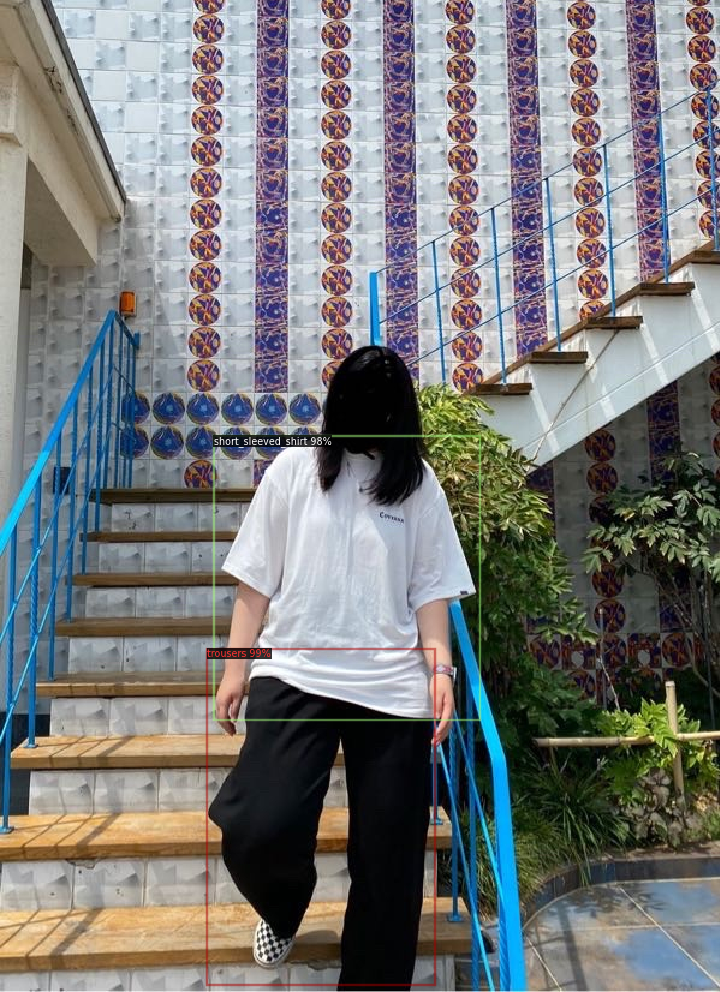

In [ ]:
from detectron2.utils.visualizer import ColorMode
im = cv2.imread('/content/drive/MyDrive/001/70_1848166_0.jpg')
outputs = predictor(im)
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

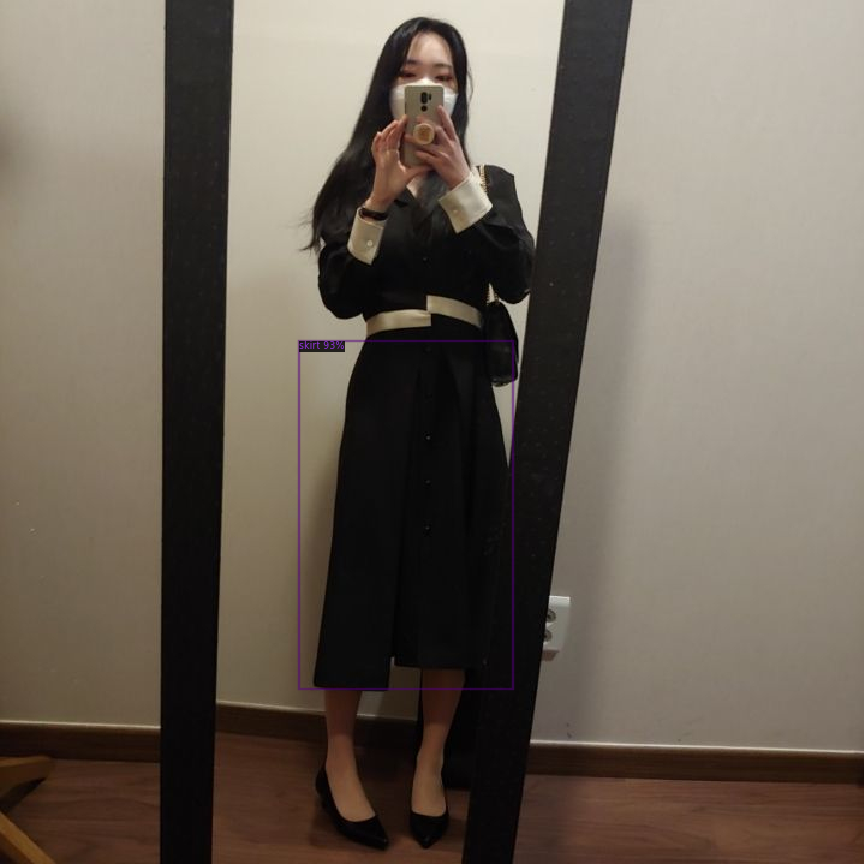

In [ ]:
from detectron2.utils.visualizer import ColorMode
from skimage import io
#i = io.imread('https://image.msscdn.net/data/estimate/1579103_0/gallery_5fba1f42bb289.jpg')
im = cv2.imread("/content/gallery_5fba1f42bb289.jpg")
outputs = predictor(im)
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from skimage import io
import cv2
# insert your url
#a = os.listdir('/content/drive/MyDrive/001')

for j in tuples[1000:1005]:
  i_sam = io.imread(j[3])
  if len(i_sam.shape) > 2 and i_sam.shape[2] == 4:
    #slice off the alpha channel
    i_sam = i_sam[:, :, :3]
  i_sam = cv2.resize(i_sam, dsize=(300, 450), interpolation=cv2.INTER_AREA)


  i_rev = io.imread(j[2])
  if len(i_rev.shape) > 2 and i_rev.shape[2] == 4:
    #slice off the alpha channel
    i_rev = i_rev[:, :, :3]
  i_rev = cv2.resize(i_rev, dsize=(300, 450), interpolation=cv2.INTER_AREA)

  out_sam = predictor(i_sam)
  out_rev = predictor(i_rev)
  print(out_sam, out_rev)
  
  v_sam = Visualizer(i_sam[:, :, ::-1],
                  metadata=moda_metadata, 
                  scale=0.8
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
      )
  v_rev = Visualizer(i_rev[:, :, ::-1],
                  metadata=moda_metadata, 
                  scale=0.8
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
      )
  print(j[3])
  v_sam = v_sam.draw_instance_predictions(out_sam["instances"].to("cpu"))
  print(j[2])
  v_rev = v_rev.draw_instance_predictions(out_rev["instances"].to("cpu"))
  cv2_imshow(v_sam.get_image()[:, :, ::])
  cv2_imshow(v_rev.get_image()[:, :, ::])

  # # crop img
  # from re import I
  # from PIL import Image

  # masks_sam = np.asarray(out_sam["instances"].pred_masks.to("cpu"))
  # masks_rev = np.asarray(out_rev["instances"].pred_masks.to("cpu"))

  # for j in range(masks_sam.shape[0]): # 마스크 수만큼 돌아가나 보군군
  #   item_mask_sam = masks_sam[j]

  #   segmentation = np.where(item_mask_sam == True)
  #   x_min = int(np.min(segmentation[1]))
  #   x_max = int(np.max(segmentation[1]))
  #   y_min = int(np.min(segmentation[0]))
  #   y_max = int(np.max(segmentation[0]))
  #   print(x_min, y_min,x_max, y_max)

  # for j in range(masks_sam.shape[0]): # 마스크 수만큼 돌아가나 보군군
  #   item_mask_sam = masks_sam[j]

  #   segmentation = np.where(item_mask_sam == True)
  #   x_min = int(np.min(segmentation[1]))
  #   x_max = int(np.max(segmentation[1]))
  #   y_min = int(np.min(segmentation[0]))
  #   y_max = int(np.max(segmentation[0]))
  #   print(x_min, y_min,x_max, y_max)

  #   cropped = Image.fromarray(i_rev[y_min:y_max, x_min:x_max, :], mode='RGB')

  #   mask_sam = Image.fromarray((item_mask_sam * 255).astype('uint8'))


  #   cropped_mask_sam = mask_sam.crop((x_min, y_min, x_max, y_max))
  #   bg = np.full((450, 300, 3), 255, np.uint8) # 흰색배경
  #   # bg = np.zeros((450, 300, 3), np.uint8) # 검정색 배경
  #   background = Image.fromarray(bg, mode='RGB')
  #   paste_position = (100,150)

  #   new_fg_image = Image.new('RGB', background.size)
  #   new_fg_image.paste(cropped, paste_position)

  #   new_alpha_mask = Image.new("L", background.size, color = 0)
  #   new_alpha_mask.paste(cropped_mask, paste_position)

  #   composite = Image.composite(new_fg_image, background, new_alpha_mask)


  #   composite_array = np.array(composite)
  #   nonzero_composite_array = np.nonzero(composite_array)
  #   np_av = np.average(nonzero_composite_array)
  #   print(np_av)
  

  #   # masks_sam, masks_rev 
  #   # masks_sam의 item_num이 해당 클래스인 것만 저장. cropped img 
  #   # masks_rev의 item_num, url, reviewId, -> 별도 DB 생성. 일단 딕셔너리나 리스트로 뽑아 두기.


  #   cv2_imshow(np.array(composite))
  #   item_num = out['instances'].pred_classes[j].item()
  #   if item_num == 4 or item_num == 5 or item_num == 8 or item_num == 9:
  #     cv2.imwrite(f"data/images_output/top/top{j}.png", np.array(composite))
  #   elif item_num == 7 or item_num == 10:
  #     cv2.imwrite(f"data/images_output/bottom/bottom{j}.png", np.array(composite))
  #   else:
  #     cv2.imwrite(f"data/images_output/others/others{j}.png", np.array(composite))

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("deepfashion3", cfg, False, output_dir="/content/drive/MyDrive/LSW/deepfashion-fasterrcnn_1")
val_loader = build_detection_test_loader(new_cfg, "deepfashion3")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

ModuleNotFoundError: ignored

Saving and reloading the model

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

In [ ]:
import torch
new_cfg = get_cfg()
new_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
new_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13
new_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
new_cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/LSW/deepfashion-fasterrcnn_1/model_final.pth"

In [ ]:
# im = cv2.imread('/content/test/IMG_2514_jpeg_jpg.rf.19de1787caef21dba070ac1b1c78e5e0.jpg')
# outputs = predictor(im)


# v = Visualizer(im[:, :, ::-1],
# metadata=MetadataCatalog.get('aquarium_train'),
# scale=2,
# instance_mode=ColorMode.IMAGE_BW)
# out = v.draw_instance_predictions(outputs['instances'].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

GET DB

In [ ]:
import pandas as pd
import sqlite3
from urllib.request import urlopen
from urllib.error import URLError, HTTPError

In [ ]:
import sqlite3
con = sqlite3.connect("/content/drive/MyDrive/3rd_project/musinsa_2nd_pr_2.db")
sql = "SELECT mid_category, reviewId ,reviewImageUrl, sampleImageUrl FROM 'review_002_002019_아노락재킷';"
cur = con.cursor()
cur.execute(sql)
tuples = cur.fetchall()
con.close()

In [ ]:
for j in tuples[900:1005]:
  print(j)

('002019', '7429205', 'https://image.msscdn.net/data/estimate/1150102_0/gallery_5de8e4d58abd7.jpg', 'https://image.msscdn.net/images/goods_img/20190910/1150102/1150102_3_500.jpg')
('002019', '7429205', 'https://image.msscdn.net/data/estimate/1150102_0/gallery_5de8e4d6b7c63.jpg', 'https://image.msscdn.net/images/goods_img/20190910/1150102/1150102_3_500.jpg')
('002019', '36319425', 'https://image.msscdn.net/data/estimate/2499384_0/gallery_638c6f7030de7.jpg', 'https://image.msscdn.net/images/goods_img/20220419/2499384/2499384_1_500.jpg')
('002019', '33246533', 'https://image.msscdn.net/data/estimate/2499384_0/gallery_633ecbcb71b5d.jpg', 'https://image.msscdn.net/images/goods_img/20220419/2499384/2499384_1_500.jpg')
('002019', '32399668', 'https://image.msscdn.net/data/estimate/2499384_0/gallery_63226e850a62a.jpg', 'https://image.msscdn.net/images/goods_img/20220419/2499384/2499384_1_500.jpg')
('002019', '32254779', 'https://image.msscdn.net/data/estimate/2499384_0/gallery_631d5bdf5c325.jp

In [ ]:
db1 = pd.read_sql('SELECT * FROM review_002_002019_아노락재킷',con)
urllist = db1.iloc[:,6]
print(len(urllist))
print(urllist)

{'instances': Instances(num_instances=0, image_height=450, image_width=300, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])} {'instances': Instances(num_instances=0, image_height=450, image_width=300, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}
https://image.msscdn.net/images/goods_img/20220307/2402289/2402289_2_500.jpg
https://image.msscdn.net/data/estimate/2402289_0/gallery_63001d66d2b84.jpg


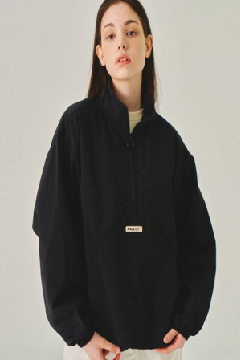

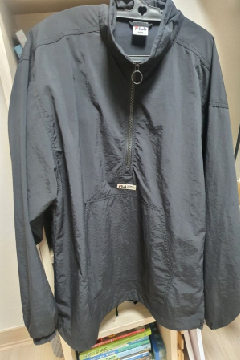

{'instances': Instances(num_instances=0, image_height=450, image_width=300, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])} {'instances': Instances(num_instances=0, image_height=450, image_width=300, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}
https://image.msscdn.net/images/goods_img/20220307/2402289/2402289_2_500.jpg
https://image.msscdn.net/data/estimate/2402289_0/gallery_62ad0b0c45e10.jpg


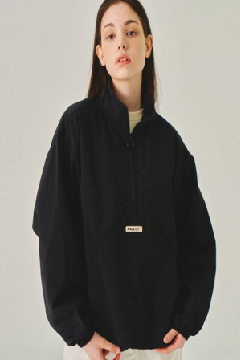

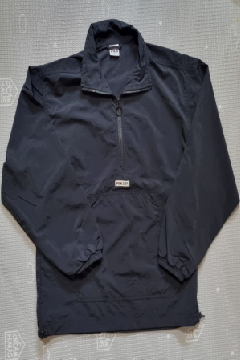

{'instances': Instances(num_instances=0, image_height=450, image_width=300, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])} {'instances': Instances(num_instances=0, image_height=450, image_width=300, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}
https://image.msscdn.net/images/goods_img/20220307/2402289/2402289_2_500.jpg
https://image.msscdn.net/data/estimate/2402289_0/gallery_62ad0b0cd7e12.jpg


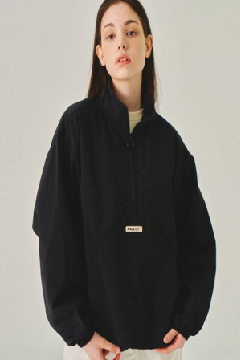

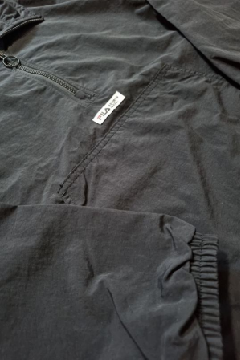

{'instances': Instances(num_instances=0, image_height=450, image_width=300, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])} {'instances': Instances(num_instances=0, image_height=450, image_width=300, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}
https://image.msscdn.net/images/goods_img/20220307/2402289/2402289_2_500.jpg
https://image.msscdn.net/data/estimate/2402289_0/gallery_62a3cfd41561e.jpg


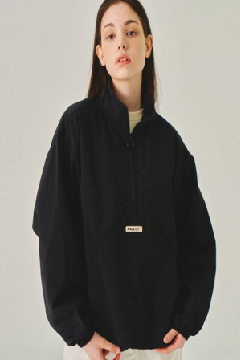

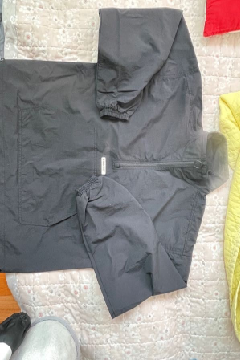

{'instances': Instances(num_instances=0, image_height=450, image_width=300, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])} {'instances': Instances(num_instances=0, image_height=450, image_width=300, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}
https://image.msscdn.net/images/goods_img/20220209/2349888/2349888_1_500.jpg
https://image.msscdn.net/data/estimate/2349888_0/gallery_6379fd6d91f03.jpg


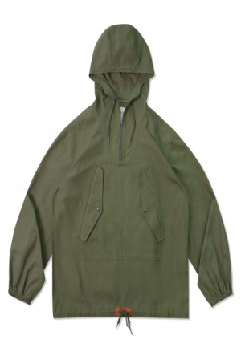

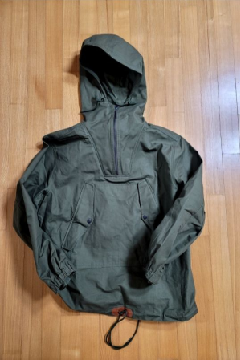

In [ ]:
from skimage import io
import cv2
# insert your url
#a = os.listdir('/content/drive/MyDrive/001')

for j in tuples[1000:1005]:
  i_sam = io.imread(j[3])
  if len(i_sam.shape) > 2 and i_sam.shape[2] == 4:
    #slice off the alpha channel
    i_sam = i_sam[:, :, :3]
  i_sam = cv2.resize(i_sam, dsize=(300, 450), interpolation=cv2.INTER_AREA)


  i_rev = io.imread(j[2])
  if len(i_rev.shape) > 2 and i_rev.shape[2] == 4:
    #slice off the alpha channel
    i_rev = i_rev[:, :, :3]
  i_rev = cv2.resize(i_rev, dsize=(300, 450), interpolation=cv2.INTER_AREA)

  out_sam = predictor(i_sam)
  out_rev = predictor(i_rev)
  print(out_sam, out_rev)
  
  v_sam = Visualizer(i_sam[:, :, ::-1],
                  metadata=moda_metadata, 
                  scale=0.8
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
      )
  v_rev = Visualizer(i_rev[:, :, ::-1],
                  metadata=moda_metadata, 
                  scale=0.8
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
      )
  print(j[3])
  v_sam = v_sam.draw_instance_predictions(out_sam["instances"].to("cpu"))
  print(j[2])
  v_rev = v_rev.draw_instance_predictions(out_rev["instances"].to("cpu"))
  cv2_imshow(v_sam.get_image()[:, :, ::])
  cv2_imshow(v_rev.get_image()[:, :, ::])

  # # crop img
  # from re import I
  # from PIL import Image

  # masks_sam = np.asarray(out_sam["instances"].pred_masks.to("cpu"))
  # masks_rev = np.asarray(out_rev["instances"].pred_masks.to("cpu"))

  # for j in range(masks_sam.shape[0]): # 마스크 수만큼 돌아가나 보군군
  #   item_mask_sam = masks_sam[j]

  #   segmentation = np.where(item_mask_sam == True)
  #   x_min = int(np.min(segmentation[1]))
  #   x_max = int(np.max(segmentation[1]))
  #   y_min = int(np.min(segmentation[0]))
  #   y_max = int(np.max(segmentation[0]))
  #   print(x_min, y_min,x_max, y_max)

  # for j in range(masks_sam.shape[0]): # 마스크 수만큼 돌아가나 보군군
  #   item_mask_sam = masks_sam[j]

  #   segmentation = np.where(item_mask_sam == True)
  #   x_min = int(np.min(segmentation[1]))
  #   x_max = int(np.max(segmentation[1]))
  #   y_min = int(np.min(segmentation[0]))
  #   y_max = int(np.max(segmentation[0]))
  #   print(x_min, y_min,x_max, y_max)

  #   cropped = Image.fromarray(i_rev[y_min:y_max, x_min:x_max, :], mode='RGB')

  #   mask_sam = Image.fromarray((item_mask_sam * 255).astype('uint8'))


  #   cropped_mask_sam = mask_sam.crop((x_min, y_min, x_max, y_max))
  #   bg = np.full((450, 300, 3), 255, np.uint8) # 흰색배경
  #   # bg = np.zeros((450, 300, 3), np.uint8) # 검정색 배경
  #   background = Image.fromarray(bg, mode='RGB')
  #   paste_position = (100,150)

  #   new_fg_image = Image.new('RGB', background.size)
  #   new_fg_image.paste(cropped, paste_position)

  #   new_alpha_mask = Image.new("L", background.size, color = 0)
  #   new_alpha_mask.paste(cropped_mask, paste_position)

  #   composite = Image.composite(new_fg_image, background, new_alpha_mask)


  #   composite_array = np.array(composite)
  #   nonzero_composite_array = np.nonzero(composite_array)
  #   np_av = np.average(nonzero_composite_array)
  #   print(np_av)
  

  #   # masks_sam, masks_rev 
  #   # masks_sam의 item_num이 해당 클래스인 것만 저장. cropped img 
  #   # masks_rev의 item_num, url, reviewId, -> 별도 DB 생성. 일단 딕셔너리나 리스트로 뽑아 두기.


  #   cv2_imshow(np.array(composite))
  #   item_num = out['instances'].pred_classes[j].item()
  #   if item_num == 4 or item_num == 5 or item_num == 8 or item_num == 9:
  #     cv2.imwrite(f"data/images_output/top/top{j}.png", np.array(composite))
  #   elif item_num == 7 or item_num == 10:
  #     cv2.imwrite(f"data/images_output/bottom/bottom{j}.png", np.array(composite))
  #   else:
  #     cv2.imwrite(f"data/images_output/others/others{j}.png", np.array(composite))

In [ ]:
from skimage import io
import cv2
# insert your url
#a = os.listdir('/content/drive/MyDrive/001')

for j in tuples[1000:1005]:
  i_sam = io.imread(j[3])
  if len(i_sam.shape) > 2 and i_sam.shape[2] == 4:
    #slice off the alpha channel
    i_sam = i_sam[:, :, :3]
  i_sam = cv2.resize(i_sam, dsize=(300, 450), interpolation=cv2.INTER_AREA)


  i_rev = io.imread(j[2])
  if len(i_rev.shape) > 2 and i_rev.shape[2] == 4:
    #slice off the alpha channel
    i_rev = i_rev[:, :, :3]
  i_rev = cv2.resize(i_rev, dsize=(300, 450), interpolation=cv2.INTER_AREA)

  out_sam = predictor(i_sam)
  out_rev = predictor(i_rev)
  print(out_sam, out_rev)
  
  v_sam = Visualizer(i_sam[:, :, ::-1],
                  metadata=moda_metadata, 
                  scale=0.8
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
      )
  v_rev = Visualizer(i_rev[:, :, ::-1],
                  metadata=moda_metadata, 
                  scale=0.8
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
      )
  print(j[3])
  v_sam = v_sam.draw_instance_predictions(out_sam["instances"].to("cpu"))
  print(j[2])
  v_rev = v_rev.draw_instance_predictions(out_rev["instances"].to("cpu"))
  cv2_imshow(v_sam.get_image()[:, :, ::])
  cv2_imshow(v_rev.get_image()[:, :, ::])

  # # crop img
  # from re import I
  # from PIL import Image

  # masks_sam = np.asarray(out_sam["instances"].pred_masks.to("cpu"))
  # masks_rev = np.asarray(out_rev["instances"].pred_masks.to("cpu"))

  # for j in range(masks_sam.shape[0]): # 마스크 수만큼 돌아가나 보군군
  #   item_mask_sam = masks_sam[j]

  #   segmentation = np.where(item_mask_sam == True)
  #   x_min = int(np.min(segmentation[1]))
  #   x_max = int(np.max(segmentation[1]))
  #   y_min = int(np.min(segmentation[0]))
  #   y_max = int(np.max(segmentation[0]))
  #   print(x_min, y_min,x_max, y_max)

  # for j in range(masks_sam.shape[0]): # 마스크 수만큼 돌아가나 보군군
  #   item_mask_sam = masks_sam[j]

  #   segmentation = np.where(item_mask_sam == True)
  #   x_min = int(np.min(segmentation[1]))
  #   x_max = int(np.max(segmentation[1]))
  #   y_min = int(np.min(segmentation[0]))
  #   y_max = int(np.max(segmentation[0]))
  #   print(x_min, y_min,x_max, y_max)

  #   cropped = Image.fromarray(i_rev[y_min:y_max, x_min:x_max, :], mode='RGB')

  #   mask_sam = Image.fromarray((item_mask_sam * 255).astype('uint8'))


  #   cropped_mask_sam = mask_sam.crop((x_min, y_min, x_max, y_max))
  #   bg = np.full((450, 300, 3), 255, np.uint8) # 흰색배경
  #   # bg = np.zeros((450, 300, 3), np.uint8) # 검정색 배경
  #   background = Image.fromarray(bg, mode='RGB')
  #   paste_position = (100,150)

  #   new_fg_image = Image.new('RGB', background.size)
  #   new_fg_image.paste(cropped, paste_position)

  #   new_alpha_mask = Image.new("L", background.size, color = 0)
  #   new_alpha_mask.paste(cropped_mask, paste_position)

  #   composite = Image.composite(new_fg_image, background, new_alpha_mask)


  #   composite_array = np.array(composite)
  #   nonzero_composite_array = np.nonzero(composite_array)
  #   np_av = np.average(nonzero_composite_array)
  #   print(np_av)
  

  #   # masks_sam, masks_rev 
  #   # masks_sam의 item_num이 해당 클래스인 것만 저장. cropped img 
  #   # masks_rev의 item_num, url, reviewId, -> 별도 DB 생성. 일단 딕셔너리나 리스트로 뽑아 두기.


  #   cv2_imshow(np.array(composite))
  #   item_num = out['instances'].pred_classes[j].item()
  #   if item_num == 4 or item_num == 5 or item_num == 8 or item_num == 9:
  #     cv2.imwrite(f"data/images_output/top/top{j}.png", np.array(composite))
  #   elif item_num == 7 or item_num == 10:
  #     cv2.imwrite(f"data/images_output/bottom/bottom{j}.png", np.array(composite))
  #   else:
  #     cv2.imwrite(f"data/images_output/others/others{j}.png", np.array(composite))

Feature Extractor
Try1

In [ ]:
from PIL import Image
from pathlib import Path
import numpy as np


from feature_extractor import FeatureExtractor

# vgg16.h5 못 받아올 때 아래 코드 2줄 활성화 후 실행
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context


if __name__ == "__main__":
    
    fe = FeatureExtractor()
        
    # top feature
    for img_path in sorted(Path("./static/img_top").glob("*.jpg")):
        print(img_path)
        
        # Extract a deep feature here
        feature = fe.extract(img=Image.open(img_path))
        
        feature_path = Path("./static/feature_top") / (img_path.stem + ".npy")
        print(feature_path)
        
        # Save the feature
        np.save(feature_path, feature)
        
    # bottom feature
    for img_path in sorted(Path("./static/img_bottom").glob("*.jpg")):
        print(img_path)
        
        # Extract a deep feature here
        feature = fe.extract(img=Image.open(img_path))
        
        feature_path = Path("./static/feature_bottom") / (img_path.stem + ".npy")
        print(feature_path)
        
        # Save the feature
        np.save(feature_path, feature)

In [ ]:
from feature_extractor import FeatureExtractor
import pymysql as pysql
from pathlib import Path

import numpy as np
import pandas as pd


# Reading img features
def load_img_list():
    '''
    local에 저장된 .npy 디렉토리에서 특징들을 뽑아와 numpy array로,
    DB에 담긴 image path와 하이퍼링크를 가져와 dataframe 형태로 반환해주는 함수
    [return]
    features_top : numpy.array -> .npy에서 읽어온 top부분 특징
    features_bottom : numpy.array -> .npy에서 읽어온 bottom부분 특징
    result : numpy.array -> DB에서 읽어온 image path와 하이퍼링크 주소. dataframe 형태
    '''
    
    # 추출된 특징들을 pandas에 담아서 정리
    features_top = []
    features_bottom = []
    
    for feature_path in sorted(Path("./static/feature_top").glob("*.npy")):
        features_top.append(np.load(feature_path))
    features_top = np.array(features_top)

    for feature_path in sorted(Path("./static/feature_bottom").glob("*.npy")):
        features_bottom.append(np.load(feature_path))
    features_bottom = np.array(features_bottom)
    
    # DB에서 table 가져와서 pandas에 담기
    sql_top = "select * from imgs_top"
    sql_bottom = "select * from imgs_bottom"
    
    conn = pysql.connect(host="db-3team-project.ckirsmdzwudh.ap-northeast-2.rds.amazonaws.com",
                        port=3306,
                        user="admin",
                        password="rladbdbsDL!",
                        db="security",
                        charset="utf8")
    
    result_top = pd.read_sql_query(sql_top, conn)    
    result_bottom = pd.read_sql_query(sql_bottom, conn)    

    result_top['path_url'] = "https://image-storage01.s3.ap-northeast-2.amazonaws.com/" + result_top['name']
    result_bottom['path_url'] = "https://image-storage01.s3.ap-northeast-2.amazonaws.com/" + result_bottom['name']

    result_top = result_top.sort_values('name')
    result_bottom = result_bottom.sort_values('name')

    return features_top, features_bottom, result_top, result_bottom
    
load_img_list()

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy as np

class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights="imagenet")
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer("fc1").output)
        

    def extract(self, img):
        img = img.resize((224, 224)).convert("RGB")
        x = image.img_to_array(img) # To np.array
        x = np.expand_dims(x, axis=0)   # (H, W, C) -> (1, H, W, C)
        x = preprocess_input(x) # Subtract avg pixel value
        feature = self.model.predict(x)[0]  # (1, 4096) -> (4096, )
        return feature / np.linalg.norm(feature)
        

In [ ]:
import numpy as np
from PIL import Image
from feature_extractor import FeatureExtractor
from datetime import datetime
from flask import Flask, request, render_template
from flask_cors import CORS
from flask_restful import Api
import flask
import base64
import cv2
from data_list import load_img_list
from img_crawling import naver_crawling
import schedule
import time
import running
import json

### 원본 코드 ###
# app = Flask(__name__)

# # Reading img features
# fe = FeatureExtractor()
# features = []
# img_paths = []

# for feature_path in Path("./static/feature").glob("*.npy"):
#     features.append(np.load(feature_path))
#     img_paths.append(Path("./static/img") / (feature_path.stem + ".jpg"))
# features = np.array(features)

# @app.route("/", methods=["GET", "POST"])
# def index():
#     if request.method == "POST":
#         file = request.files["query_img"]
        
#         # Save query img
#         img = Image.open(file.stream) # PIL image
#         uploaded_img_path = "static/uploaded/" + datetime.now().isoformat().replace(":", ".") + "_" + file.filename
#         img.save(uploaded_img_path)
        
#         # Run Search
#         query = fe.extract(img)
#         dists = np.linalg.norm(features - query, axis=1) # L2 distance to the features
#         ids = np.argsort(dists)[:30]    # Top 30 results
#         scores = [(dists[id], img_paths[id]) for id in ids]
        
#         print(scores)
        
#         return render_template("index.html", query_path=uploaded_img_path, scores=scores)
#     else:
#         return render_template("index.html")

# if __name__=="__main__":
#     app.run()
     
### 여기까지 ###




app = Flask(__name__)
CORS(app, supports_credentials=True) # 다른 포트번호에 대한 보안 제거
api = Api(app)

# Reading img features
fe = FeatureExtractor()

features_top, features_bottom, df_top, df_bottom = load_img_list()

@app.route("/upload", methods=["POST"])
def upload():
    if request.method == "POST":
        file = request.get_json()["file"].split(",")[1]
        
        decoded_file = base64.b64decode(file)
        
        img_np = np.fromstring(decoded_file, dtype=np.uint8)
        
        img = cv2.imdecode(img_np, flags=cv2.IMREAD_COLOR)
        
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # img = Image.fromarray(img.astype('uint8'))
        
        # img.show() 
        
        # image_parsing {"outer" : [np.array, ...], "shortsleeve" : [np.array, ...], }
        array_top, array_bottom = running.cloth_seg(img)
        dict_top = {}
        dict_bottom = {}
        
        if array_top:
            for key in array_top.keys():
                img_top = Image.fromarray(array_top.get(key).astype('uint8'))
                
                # Run Search
                query_top = fe.extract(img_top)
                dists_top = np.linalg.norm(features_top - query_top, axis=1)
                ids_top = np.argsort(dists_top)[:100] # top result sort
                
                result_img_path_top = [df_top.iloc[id]['path_url'] for id in ids_top]
                result_img_link_top = [df_top.iloc[id]['url'] for id in ids_top]
                result_img_score_top = [float(dists_top[id]) for id in ids_top] # float32 타입으로 되어 있는 것을 float 타입으로 바꿔주어야지 json으로 변경 가능. 리스트에 있어도 마찬가지
                
                dict_top[key] = {"result_img_path_top" : result_img_path_top,
                                "result_img_link_top" : result_img_link_top,
                                "result_img_score_top" : result_img_score_top}
        
            
        if array_bottom:
            for key in array_bottom.keys():
                img_bottom = Image.fromarray(array_bottom.get(key).astype('uint8'))
            
                # Run Search
                query_bottom = fe.extract(img_bottom)
                dists_bottom = np.linalg.norm(features_bottom - query_bottom, axis=1)
                ids_bottom = np.argsort(dists_bottom)[:100] # top result sort
                
                result_img_path_bottom = [df_bottom.iloc[id]['path_url'] for id in ids_bottom]
                result_img_link_bottom = [df_bottom.iloc[id]['url'] for id in ids_bottom]
                result_img_score_bottom = [float(dists_bottom[id]) for id in ids_bottom] # float32 타입으로 되어 있는 것을 float 타입으로 바꿔주어야지 json으로 변경 가능. 리스트에 있어도 마찬가지
                
                dict_bottom[key] = {"result_img_path_bottom" : result_img_path_bottom,
                                                "result_img_link_bottom" : result_img_link_bottom,
                                                "result_img_score_bottom" : result_img_score_bottom}
        
        
        return flask.jsonify({"result" : "true",
                              "number_of_top_category" : str(len(array_top)),
                              "top" : dict_top,
                              "number_of_bottom_category" : str(len(array_bottom)),
                              "bottom" : dict_bottom})
    else:
        return flask.jsonify({"result" : "false"})
    

if __name__=="__main__":
    # app.run(host=0.0.0.0, port=5000) 모든 호스트로 접속 가능.
    app.run()
    
    # # 크롤링 자동화
    # schedule.every().wednesday.at("15:06").do(naver_crawling)
    # while True:
    #     schedule.run_pending()
    #     time.sleep(1)